In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import yfinance
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set()

In this Notebook we will look at using the Transformer architecture to approximate train a neural network that will have the objective function of a multi-period optimization. We will compare its performance towards the single period optimization model. The following parameters are used, we will use the weekly return of 50 arbitrarily selected stocks that are meant to be diversified. 

For the MPO optimization, we will estimate portfolio weights for the next 4 timestamps, namely the next 4 weeks of trading, in comparison to the single-period which only trades weekly. 

In [2]:
stocks = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JNJ', 'JPM', 'V', 'PG', 'UNH', 'NVDA', 
    'DIS', 'HD', 'MA', 'PFE', 'BAC', 'KO', 'PEP', 'MRK', 'WMT', 'INTC', 
    'CSCO', 'T', 'VZ', 'CMCSA', 'CVX', 'XOM', 'IBM', 'MMM', 'NKE', 'ORCL', 
    'GE', 'WFC', 'MCD', 'C', 'TXN', 'BA', 'LLY', 'ABT', 'BMY', 'GS', 
    'SBUX', 'CAT', 'HON', 'AXP', 'MDT', 'DUK', 'RTX', 'LOW', 'UPS', 'CVS',
]

In [3]:
dataset = yfinance.download(stocks, end="2024-07-01")

[*********************100%%**********************]  50 of 50 completed


In [4]:
dataset = dataset["Adj Close"]
dataset = dataset.dropna()

In [5]:
return_data = dataset.pct_change().fillna(0)
return_data.head(), return_data.tail()

(Ticker          AAPL       ABT      AMZN       AXP        BA       BAC  \
 Date                                                                     
 2008-03-19  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 2008-03-20  0.027763  0.023350  0.043038  0.094762  0.018380  0.085581   
 2008-03-24  0.046972 -0.004132  0.037710  0.031100  0.019920  0.014095   
 2008-03-25  0.010392 -0.016237 -0.010270  0.002109 -0.005112 -0.034865   
 2008-03-26  0.028940 -0.009169 -0.018225 -0.045254  0.005270 -0.027581   
 
 Ticker           BMY         C       CAT     CMCSA  ...      SBUX         T  \
 Date                                                ...                       
 2008-03-19  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
 2008-03-20  0.000000  0.102401  0.001220  0.002070  ...  0.001714  0.022191   
 2008-03-24 -0.008854  0.034222  0.029938  0.043905  ...  0.020536  0.032022   
 2008-03-25  0.015515  0.006446  0.008023  0.016329  ...  0.005589 -0.000

### Data splitting. Train and Test

Splitting the data into train and test set and setting a 30% ratio for the test set

In [6]:
X_train, X_test = train_test_split(return_data, test_size=0.3, shuffle=False, random_state=7)
X_train.shape, X_test.shape

((2868, 50), (1230, 50))

In [7]:
X_train = X_train.groupby([X_train.index.isocalendar().year, X_train.index.isocalendar().week]).sum()

In [8]:
new_idx = pd.to_datetime(['{}-{}0'.format(i, j) for i, j in X_train.index], format="%Y-%W%w")
X_train = X_train.set_index(new_idx)

We have a sequence of 52 data points which is a year's worth of data as inputs and we will use them to optimize for the next 4 weeks of data points and 1 week for the single period

In [9]:
lookback_window = 52 # last 1 year
predict_period = 4 # predicting next 4 weeks of data

In [10]:
class FinancialDataset(Dataset):
    def __init__(self, dataset, L, T):
        self.dataset = dataset
        self.L = L
        self.T = T

    def __len__(self):
        return len(self.dataset) - self.L - self.T

    def __getitem__(self, idx):
        X_batch = self.dataset[idx:idx+self.L, :]
        y_batch = self.dataset[idx+self.L:idx+self.L+self.T, :]
        return (torch.FloatTensor(X_batch), 
                torch.FloatTensor(y_batch))

In [11]:
BATCH_SIZE = 16

In [12]:
X_train_iter_mp = DataLoader(dataset=FinancialDataset(dataset=X_train.values, L=lookback_window, T=predict_period), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

X_train_iter_sp = DataLoader(dataset=FinancialDataset(dataset=X_train.values, L=lookback_window, T=1), 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)

In [13]:
for X in X_train_iter_mp:
    print(X[0].shape, X[1].shape)
    break

torch.Size([16, 52, 50]) torch.Size([16, 4, 50])


In [14]:
MAX_EPOCHS = 30

In [15]:
NUM_STOCKS = len(stocks)

Transformer Architecture

In [16]:
class TimeToVecEmbedding(nn.Module):
    def __init__(self, k):
        super(TimeToVecEmbedding, self).__init__()
        self.k = k
        self.dense = nn.Linear(in_features=k, out_features=k, bias=True)

    def forward(self, X):
        X = self.dense(X)
        time_encoding = torch.sin(X[:, :, 1:]) # periodic activation function
        time_encoding = torch.cat([X[:, :, 0].unsqueeze(2), time_encoding], dim=-1)
        return time_encoding

class TransformerNet(nn.Module):
    def __init__(self, num_features, num_assets, num_head, num_layers, W, T):
        super(TransformerNet, self).__init__()
        self.W = W - T
        self.T = T
        self.num_features = num_features
        self.num_assets = num_assets
        self.t2v_enc = TimeToVecEmbedding(k=self.W)
        self.t2v_dec = TimeToVecEmbedding(k=self.T)
        self.transformer = nn.Transformer(d_model=num_features, 
                                          nhead=num_head, 
                                          num_encoder_layers=num_layers, 
                                          num_decoder_layers=num_layers,
                                          batch_first=True)
        self.fcl = nn.Linear(in_features=num_features*T, out_features=num_assets*T)
        self.dropout = nn.Dropout(p=0.25)
        self.norm = nn.Softmax(dim=2)

    def forward(self, X):
        X_ = X[:, :self.W, :]
        y_ = X[:, -self.T:, :]
        X_ = torch.permute(X_, (0,2,1))
        y_ = torch.permute(y_, (0,2,1))
        X_emb = self.t2v_enc(X_)
        X_emb = torch.permute(X_emb, (0,2,1))
        y_emb = self.t2v_dec(y_)
        y_emb = torch.permute(y_emb, (0,2,1))
        logits = self.transformer(src=X_emb, tgt=y_emb)
        logits = logits.view(-1, self.T*self.num_assets)
        logits = self.dropout(self.fcl(logits))
        logits = logits.view(-1, self.T, self.num_assets)
        logits = self.norm(logits)
        return logits
    


In [17]:
transformer_model = TransformerNet(num_features=NUM_STOCKS, 
                                   num_assets=NUM_STOCKS,
                                   num_head=25, 
                                   num_layers=10,
                                   W=lookback_window,
                                   T=predict_period)
transformer_model

/opt/homebrew/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TransformerNet(
  (t2v_enc): TimeToVecEmbedding(
    (dense): Linear(in_features=48, out_features=48, bias=True)
  )
  (t2v_dec): TimeToVecEmbedding(
    (dense): Linear(in_features=4, out_features=4, bias=True)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-9): 10 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
          )
          (linear1): Linear(in_features=50, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=50, bias=True)
          (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((5

In [18]:
class DeepModel(pl.LightningModule):
    def __init__(self, model, loss_function):
        super().__init__()
        self.model = model
        self.loss_function = loss_function

    def forward(self, X):
        X = X.unsqueeze(0)
        weights = self.model(X.float())
        weights = weights.squeeze(0)
        return weights

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-5)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        trading_weights = self.model(X)
        loss = self.loss_function(trading_weights, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)
        return loss

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        trading_weights = self.model(X)
        loss = self.loss_function(trading_weights, y)
        self.log("test_loss", loss, on_step=True, on_epoch=False, prog_bar=True, logger=False)
        return loss

Optimization Objective is as following:
1. Multi period optimization uses the next 4 weeks of data to and focuses on maximizing the sum of these 4 weeks of data using the mpo objective.
2. Single period optimization uses only the next week of data and maximizes its objective

In [22]:
class MultiPeriodOptimizationObjective(nn.Module):
    def __init__(self, holding_cost=0, trading_cost=0.01, risk_aversion_coeff=0.5):
        super(MultiPeriodOptimizationObjective, self).__init__()
        self.holding_cost=holding_cost
        self.trading_cost=trading_cost
        self.risk_aversion_coeff=risk_aversion_coeff

    def forward(self, weights_t, mean_returns):
        portfolio_returns = (weights_t*mean_returns).sum(2)
        portfolio_Sigma = self.batch_cov(mean_returns)
        portfolio_variance = (weights_t@(portfolio_Sigma@torch.permute(weights_t, (0,2,1)))).sum(dim=2)
        delta_weights = (weights_t[:, 1:, :] - weights_t[:, :-1, :]).abs()
        portfolio_trade_cost = (self.trading_cost*delta_weights).sum((2,1)).reshape((-1,1))
        mpo_objective = portfolio_returns - self.risk_aversion_coeff*portfolio_variance - portfolio_trade_cost
        mpo_objective = mpo_objective.sum(dim=1).mean()
        return -mpo_objective

    def batch_cov(self, mu_returns):
        B, N, D = mu_returns.size()
        mean = mu_returns.mean(dim=1).unsqueeze(1)
        diffs = (mu_returns - mean).reshape(B * N, D)
        prods = torch.bmm(diffs.unsqueeze(2), diffs.unsqueeze(1)).reshape(B, N, D, D)
        bcov = prods.sum(dim=1) / (N - 1)  # Unbiased estimate
        return bcov  # (B, D, D)


class SinglePeriodOptimizationObjective(nn.Module):
    def __init__(self, holding_cost=0, trading_cost=0.01, risk_aversion_coeff=0.5):
        super(SinglePeriodOptimizationObjective, self).__init__()
        self.holding_cost=holding_cost
        self.trading_cost=trading_cost
        self.risk_aversion_coeff=risk_aversion_coeff
    
    def forward(self, weights_t, mean_returns):
        weights = weights_t.squeeze(1)
        mu_returns = mean_returns.squeeze(1)
        portfolio_returns = (weights*mu_returns).sum(1)
        portfolio_variance = torch.var(mean_returns, dim=2).flatten()
        spo_objective = portfolio_returns - self.risk_aversion_coeff*portfolio_variance - self.trading_cost
        spo_objective = spo_objective.mean()
        return -spo_objective
    

In this experiment, we will use 0 trading and 0 holding cost with a risk aversion coefficient of 0.2. Later, we will incorporate more realistic trading costs and holding costs to simulate more realistic trading environment.

In [23]:
mp_objective_func = MultiPeriodOptimizationObjective(
    holding_cost=0,
    trading_cost=0,
    risk_aversion_coeff=0.2)

sp_objective_func = SinglePeriodOptimizationObjective(
    holding_cost=0,
    trading_cost=0,
    risk_aversion_coeff=0.2
)

In [24]:
multi_period_transformer = DeepModel(model=TransformerNet(num_features=NUM_STOCKS,
                                                      num_assets=NUM_STOCKS,
                                                      num_head=25,
                                                      num_layers=10,
                                                      W=lookback_window,
                                                      T=predict_period),
                                 loss_function=mp_objective_func)

single_period_transformer = DeepModel(model=TransformerNet(num_features=NUM_STOCKS,
                                                           num_assets=NUM_STOCKS,
                                                           num_head=25,
                                                           num_layers=10,
                                                           W=lookback_window,
                                                           T=1),
                                 loss_function=sp_objective_func)

/opt/homebrew/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Multi period model Training

In [26]:
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, logger=False, enable_checkpointing=False)
trainer.fit(model=multi_period_transformer, train_dataloaders=X_train_iter_mp)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                             | Params
-------------------------------------------------------------------
0 | model         | TransformerNet                   | 4.5 M 
1 | loss_function | MultiPeriodOptimizationObjective | 0     
-------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.967    Total estimated model params size (MB)
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 34/34 [00:06<00:00,  5.18it/s, train_loss_step=-0.0119, train_loss_epoch=-0.0207]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 34/34 [00:06<00:00,  5.18it/s, train_loss_step=-0.0119, train_loss_epoch=-0.0207]


In [27]:
X_test_data = []
for i in range(len(X_test) - lookback_window - predict_period):
    hist_data = X_test.iloc[i:i+lookback_window]
    pred_data = X_test.iloc[i+lookback_window:i+lookback_window+predict_period]
    X_test_data.append([hist_data.values, pred_data])

In [28]:
X_test_data = X_test_data[::4]
len(X_test_data)

294

In [29]:
multi_period_transformer.eval()

DeepModel(
  (model): TransformerNet(
    (t2v_enc): TimeToVecEmbedding(
      (dense): Linear(in_features=48, out_features=48, bias=True)
    )
    (t2v_dec): TimeToVecEmbedding(
      (dense): Linear(in_features=4, out_features=4, bias=True)
    )
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-9): 10 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=50, out_features=50, bias=True)
            )
            (linear1): Linear(in_features=50, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=50, bias=True)
            (norm1): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((50,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.

In [50]:
with torch.no_grad():
    result_mpo = [[multi_period_transformer(torch.FloatTensor(x)), y] for x,y in X_test_data]

result_mpo = [w.numpy()*mu_returns for w,mu_returns in result_mpo]
result_mpo = pd.concat(result_mpo)
result_mpo = result_mpo.sum(1)
result_mpo_cum = np.cumsum(result_mpo)

### Single period model Training

In [31]:
trainer_2 = pl.Trainer(max_epochs=MAX_EPOCHS, logger=False, enable_checkpointing=False)
trainer_2.fit(model=single_period_transformer, train_dataloaders=X_train_iter_sp)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                              | Params
--------------------------------------------------------------------
0 | model         | TransformerNet                    | 4.5 M 
1 | loss_function | SinglePeriodOptimizationObjective | 0     
--------------------------------------------------------------------
4.5 M     Trainable params
0         Non-trainable params
4.5 M     Total params
17.817    Total estimated model params size (MB)
/opt/homebrew/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Epoch 29: 100%|██████████| 34/34 [00:06<00:00,  5.29it/s, train_loss_step=0.000459, train_loss_epoch=-0.00686] 

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 34/34 [00:06<00:00,  5.29it/s, train_loss_step=0.000459, train_loss_epoch=-0.00686]


In [32]:
X_test_data_sp = []
for i in range(len(X_test) - lookback_window - 1):
    hist_data = X_test.iloc[i:i+lookback_window]
    pred_data = X_test.iloc[i+lookback_window:i+lookback_window+1]
    X_test_data_sp.append([hist_data.values, pred_data])

In [54]:
with torch.no_grad():
    result_spo = [[single_period_transformer(torch.FloatTensor(x)), y] for x,y in X_test_data]

result_spo = [w.numpy()*mu_returns for w,mu_returns in result_spo]
result_spo = pd.concat(result_spo)
result_spo = result_spo.sum(1)
result_spo_cum = np.cumsum(result_spo)

The portfolio's cumulative return from both MPO and SPO strategies are as following: 

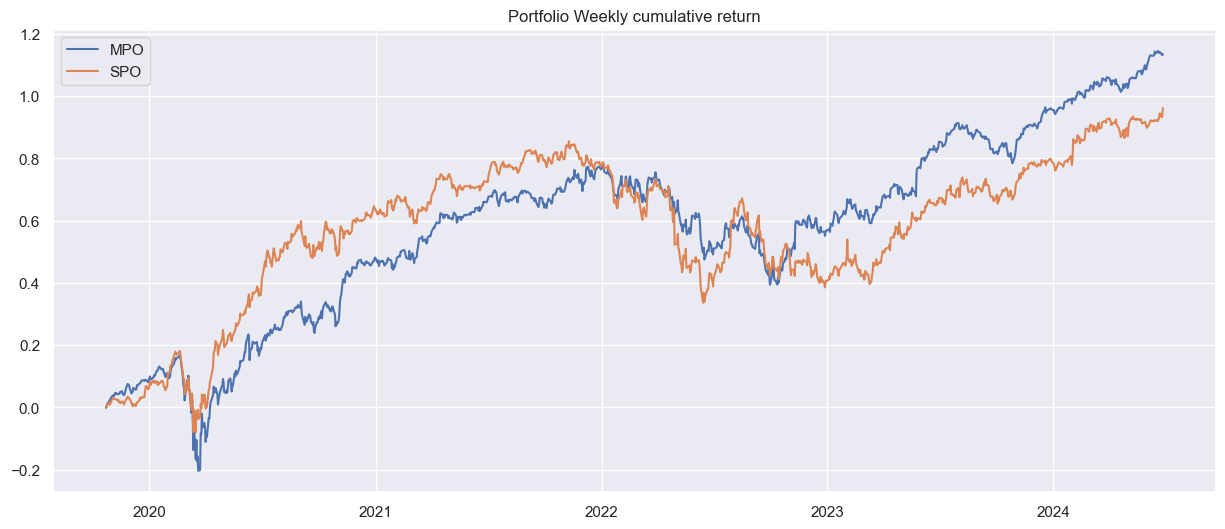

In [95]:
plt.figure(figsize=(15,6))
plt.plot(result_mpo_cum, label="MPO")
plt.plot(result_spo_cum, label="SPO")
plt.title("Portfolio Weekly cumulative return")
plt.legend()
plt.show()

We can see above that the Single period model does have a larger cumulative return than the Multi period model. However, we can also notice that the stability of the MPO portfolio is higher than the SPO portfolio. This is visible through the display of the rolling 6 month Sharpe ratio of both these portfolios. The results are as follows:

In [92]:
result_mpo_sr = result_mpo.groupby([result_mpo.index.year, result_mpo.index.month]).sum()
result_mpo_sr.index = pd.to_datetime(['{}-{}'.format(i,j) for i,j in result_mpo_sr.index])
result_mpo_sr = result_mpo_sr.rolling(window=6).apply(lambda x: x.mean()/x.std()).dropna()
result_spo_sr = result_spo.groupby([result_spo.index.year, result_spo.index.month]).sum()
result_spo_sr.index = pd.to_datetime(['{}-{}'.format(i,j) for i,j in result_spo_sr.index])
result_spo_sr = result_spo_sr.rolling(window=6).apply(lambda x: x.mean()/x.std()).dropna()

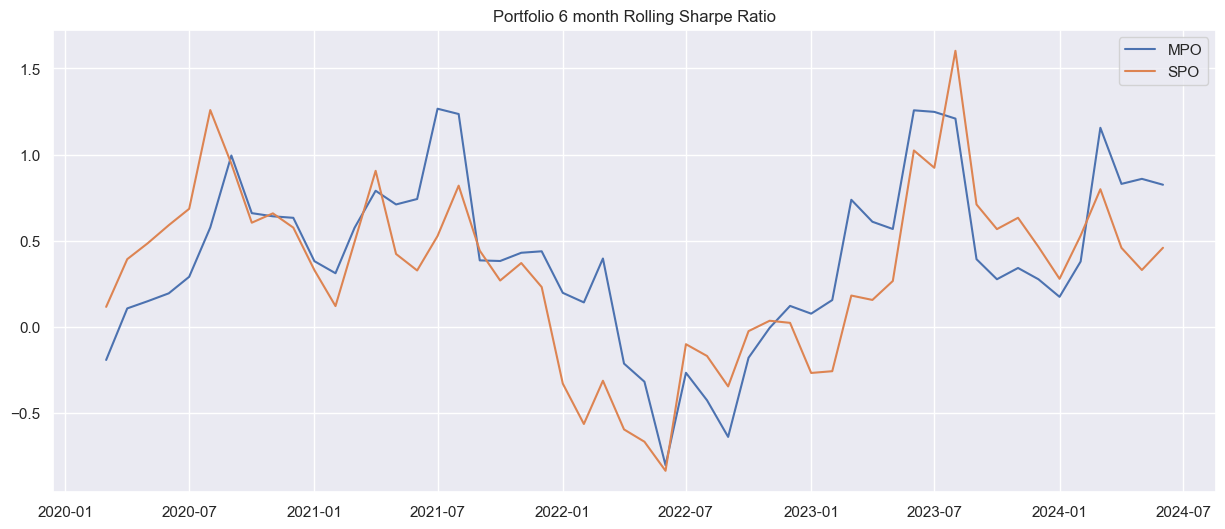

In [94]:
plt.figure(figsize=(15,6))
plt.plot(result_mpo_sr, label="MPO")
plt.plot(result_spo_sr, label="SPO")
plt.title("Portfolio 6 month Rolling Sharpe Ratio")
plt.legend()
plt.show()

We can see here that the Sharpe Ratio of the Single period model is more noisy than the Sharpe Ratio of the multi period model. This makes for an important argument for the use of multi-period especially in larger and more passive funds such as ETFs. The ability to plan the increase and decrease in portfolio allocations while taking into account the transaction costs and covariances does make the portfolio more stable and hence less volatile. 